In [1]:
import time

from matplotlib import pyplot as plt
from mne import set_log_level

from mne_lsl.datasets import sample
from mne_lsl.player import PlayerLSL as Player
from mne_lsl.stream import StreamLSL as Stream

set_log_level("WARNING")

SHA256 hash of downloaded file: e00696336c8768b4caacfa4ca1c96d124064021efbb082e27c6d9c4dbd703949
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [2]:
fname = sample.data_path() / "sample-ant-raw.fif"
player = Player(fname).start()
player.info

Failed to download 'sample-ant-raw.fif'. Will attempt the download again 2 more times.


Measurement date,Unknown
Experimenter,mne_anonymize
Participant,Unknown
Digitized points,Not available
Good channels,"63 EEG, 2 EOG, 1 Galvanic skin response, 1 ECG, 1 Stimulus"
Bad channels,None
EOG channels,"vEOG, hEOG"
ECG channels,ECG
Sampling frequency,1024.00 Hz
Highpass,0.00 Hz
Lowpass,512.00 Hz


In [5]:
sfreq = player.info["sfreq"]
chunk_size = player.chunk_size
interval = chunk_size / sfreq  # in seconds
print(f"Interval between 2 push operations: {interval} seconds.")

Interval between 2 push operations: 0.0625 seconds.


In [6]:
stream = Stream(bufsize=2).connect()
stream.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"63 EEG, 2 EOG, 1 Galvanic skin response, 1 ECG, 1 Stimulus"
Bad channels,None
EOG channels,"vEOG, hEOG"
ECG channels,ECG
Sampling frequency,1024.00 Hz
Highpass,0.00 Hz
Lowpass,512.00 Hz


In [7]:
ch_types = stream.get_channel_types(unique=True)
print(f"Channel types included: {', '.join(ch_types)}")

Channel types included: eeg, eog, gsr, ecg, stim


In [8]:
stream.pick("eeg")  # channel selection
assert "CPz" not in stream.ch_names  # reference absent from the data stream
stream.add_reference_channels("CPz")
stream.set_eeg_reference("average")
stream.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1024.00 Hz
Highpass,0.00 Hz
Lowpass,512.00 Hz


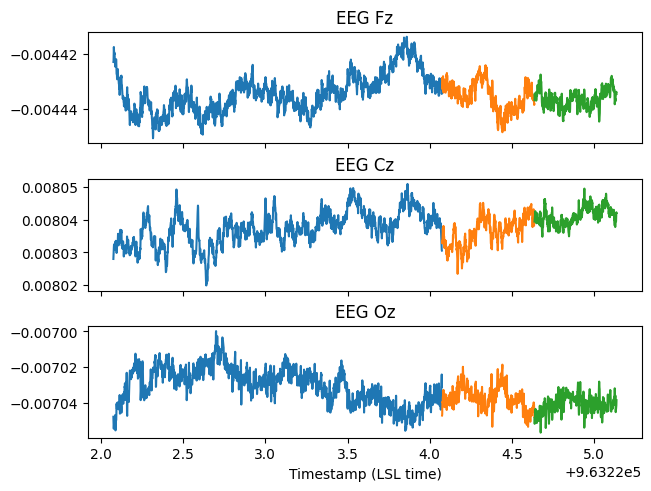

In [10]:
picks = ("Fz", "Cz", "Oz")  # channel selection
f, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True)
for _ in range(3):  # acquire 3 separate window
    # figure how many new samples are available, in seconds
    winsize = stream.n_new_samples / stream.info["sfreq"]
    # retrieve and plot data
    data, ts = stream.get_data(winsize, picks=picks)
    for k, data_channel in enumerate(data):
        ax[k].plot(ts, data_channel)
    time.sleep(0.5)
for k, ch in enumerate(picks):
    ax[k].set_title(f"EEG {ch}")
ax[-1].set_xlabel("Timestamp (LSL time)")
plt.show()